# Model 1: Transfer Learning with VGG16

**Öğrenci Bilgileri:**
- **Adı:** Eren Ali
- **Soyadı:** Koca
- **Okul Numarası:** 2212721021
- **GitHub Repo:** https://github.com/erennali/CNN_airpods_magicmouse

---

Bu model, ImageNet ağırlıkları kullanarak VGG16 mimarisi ile transfer learning uygular. AirPods ve Magic Mouse görüntülerini sınıflandırmak için fine-tuning yapılmıştır.

## 📁 Google Drive Bağlantısı

**Neden Drive'a bağlanıyoruz?**
- Uyg1 klasörü Drive'da olacak
- Dataset ve notebook dosyaları Drive'dan erişilecek
- Model dosyası (.h5) otomatik olarak Drive'a kaydedilecek
- Oturum kapansa bile dosyalar kaybolmayacak

**Mount İşlemi:**
- `from google.colab import drive` → Colab'ın Drive modülünü yükler
- `drive.mount('/content/drive')` → Drive'ı /content/drive klasörüne bağlar
- İzin vermeni isteyecek, Google hesabınla giriş yap

In [17]:
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive başarıyla bağlandı!")
print("📂 Drive dosyalarınız: /content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive başarıyla bağlandı!
📂 Drive dosyalarınız: /content/drive/MyDrive/


## 🔧 Proje Yolunun Ayarlanması

**Path Yapısı:**
```
/content/drive/MyDrive/Uyg1/
├── model1.ipynb (bu notebook)
├── dataset/
│   ├── airpods/
│   │   ├── img_001.jpg
│   │   ├── img_002.jpg
│   │   └── ...
│   └── magic_mouse/
│       ├── img_001.jpg
│       ├── img_002.jpg
│       └── ...
└── model1_transfer_learning.h5 (eğitim sonrası oluşacak)
```

**Önemli Notlar:**
- `PROJECT_PATH`: Uyg1 klasörünün Drive'daki yolu
- `os.chdir()`: Çalışma dizinini Uyg1 klasörüne değiştirir
- Böylece `dataset/` yazınca otomatik olarak Drive'daki dataset'i bulur

In [18]:
import os

PROJECT_PATH = '/content/drive/MyDrive/Uyg1'
os.chdir(PROJECT_PATH)

print(f"✅ Çalışma dizini: {os.getcwd()}")
print(f"📂 Bu klasördeki dosyalar: {os.listdir('.')}")

✅ Çalışma dizini: /content/drive/MyDrive/Uyg1
📂 Bu klasördeki dosyalar: ['model1.ipynb', 'requirements.txt', '.gitignore', '.DS_Store', 'prepare_dataset.py', 'README.md', 'model2.ipynb', 'model3.ipynb', '.git', 'dataset']


In [19]:
import tensorflow as tf
import keras
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPU Available: {num_gpus}")

if num_gpus > 0:
    print("✅ GPU aktif - Eğitim hızlı olacak!")
else:
    print("⚠️ GPU bulunamadı - Runtime -> Change runtime type -> GPU seçin")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU Available: 1
✅ GPU aktif - Eğitim hızlı olacak!


## 📚 Gerekli Kütüphanelerin İçe Aktarılması

Bu bölümde, transfer learning tabanlı CNN modelimizi oluşturmak ve eğitmek için gerekli tüm kütüphaneleri içe aktarıyoruz:

- **TensorFlow & Keras**: Derin öğrenme modellerini oluşturmak için kullanılan ana framework
- **VGG16**: ImageNet üzerinde önceden eğitilmiş state-of-the-art CNN mimarisi (transfer learning için)
- **ImageDataGenerator**: Görüntü verilerini yüklemek ve ön işleme tabi tutmak için kullanılır
- **Dense, Flatten, Dropout**: Model mimarisinde kullanılacak katmanlar
  - **Dense**: Tam bağlantılı (fully connected) katman
  - **Flatten**: Çok boyutlu veriyi tek boyuta dönüştürür
  - **Dropout**: Aşırı öğrenmeyi (overfitting) önlemek için rastgele nöronları devre dışı bırakır
- **Model**: Keras'ta özel model yapıları oluşturmak için kullanılır
- **Adam**: Optimize edici algoritma (öğrenme sürecini yönetir)
- **matplotlib.pyplot**: Eğitim sonuçlarını grafiklerle görselleştirmek için
- **numpy**: Sayısal işlemler ve dizi manipülasyonları için
- **os**: Dosya ve klasör işlemleri için

In [20]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25
DATASET_PATH = 'dataset/'

print("=" * 50)

print("📊 HİPERPARAMETRELER")
print(f"\n✅ Ayarlar GPU optimizasyonu için hazır!")

print("=" * 50)
print("=" * 50)

print(f"IMG_SIZE      : {IMG_SIZE} x {IMG_SIZE} pixels")
print(f"DATASET_PATH  : {DATASET_PATH}")

print(f"BATCH_SIZE    : {BATCH_SIZE} görüntü/batch")
print(f"EPOCHS        : {EPOCHS} epoch")

📊 HİPERPARAMETRELER

✅ Ayarlar GPU optimizasyonu için hazır!
IMG_SIZE      : 224 x 224 pixels
DATASET_PATH  : dataset/
BATCH_SIZE    : 32 görüntü/batch
EPOCHS        : 25 epoch


## ⚙️ Hiperparametrelerin Tanımlanması

Bu bölümde modelimizin eğitimi için kullanılacak temel parametreleri belirliyoruz:

### 📐 IMG_SIZE = 224
**Ne işe yarar?**
- Tüm görüntüleri 224x224 piksel boyutuna yeniden boyutlandırır

**Neden 224?**
- VGG16 modeli ImageNet'te 224x224 boyutunda eğitilmiştir
- Bu boyut VGG16'nın optimal performans göstermesi için idealdir
- Daha küçük boyut (örn. 128) → Daha hızlı ama daha düşük accuracy
- Daha büyük boyut (örn. 384) → Daha yavaş ve GPU belleği sorunları

**Bizim durumumuz:** GPU var, 224 optimal ✅

---


### 📦 BATCH_SIZE = 32**Önemli:** `flow_from_directory()` fonksiyonu klasör isimlerini otomatik olarak sınıf etiketleri olarak kullanır!

**Ne işe yarar?**

- Her iterasyonda modele kaç görüntü verileceğini belirler```

- 32 görüntü birden işlenir → ağırlıklar güncellenir    └── ...

    ├── img_001.jpg

**Neden 32?**└── magic_mouse/   → Sınıf 2

- Küçük batch (8-16): Daha fazla güncelleme, daha iyi öğrenme ama yavaş│   └── ...

- Orta batch (32): Hız ve performans dengesi → **En yaygın tercih**│   ├── img_001.jpg

- Büyük batch (64-128): Çok hızlı ama overfitting riski, GPU belleği gerekir├── airpods/       → Sınıf 1

dataset/

**Bizim durumumuz:** Colab GPU ile 32 mükemmel çalışır ✅```

**Yapı:**

---

- Görüntülerin bulunduğu klasörün yolu

### 🔄 EPOCHS = 25**Ne işe yarar?**

**Ne işe yarar?**### 📂 DATASET_PATH = 'dataset/'

- Model, tüm eğitim verisini kaç kez görecek

---

**Neden 25?**

- Transfer learning için genellikle 20-30 epoch yeterlidir**Bizim durumumuz:** 25 epoch optimal denge ✅

- VGG16 zaten eğitilmiş, sadece fine-tuning yapıyoruz

- Az epoch (10): Underfitting riski, model yeterince öğrenemez- Çok epoch (50+): Overfitting riski, validation loss artmaya başlar

In [21]:
print("📊 Veri setini yüklüyorum ve augmentation uyguluyorum...\n")

datagen = ImageDataGenerator(
    rescale=1./255,              # [0,255] → [0,1] normalizasyon
    rotation_range=20,           # ±20 derece rastgele döndürme
    width_shift_range=0.2,       # Yatayda %20 kaydırma
    height_shift_range=0.2,      # Dikeyde %20 kaydırma
    horizontal_flip=True,        # Yatay çevirme
    validation_split=0.2         # %20 validation, %80 training
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,                # 'dataset/' klasörü
    target_size=(IMG_SIZE, IMG_SIZE),  # 224x224'e yeniden boyutlandır
    batch_size=BATCH_SIZE,       # 32 görüntü/batch
    class_mode='categorical',    # 2 sınıf için one-hot encoding
    subset='training',           # Eğitim seti (%80)
    shuffle=True                 # Her epoch'ta karıştır
)
print(f"✅ Sınıflar: {list(train_generator.class_indices.keys())}")

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',         # Doğrulama seti (%20)
    shuffle=False                # Karıştırma, tutarlı sonuçlar için
)
print(f"✅ Validation görüntüler: {validation_generator.samples}")

print(f"\n✅ Training görüntüler: {train_generator.samples}")

📊 Veri setini yüklüyorum ve augmentation uyguluyorum...

Found 105 images belonging to 2 classes.
✅ Sınıflar: ['airpods', 'magic_mouse']
Found 25 images belonging to 2 classes.
✅ Validation görüntüler: 25

✅ Training görüntüler: 105


## 📂 Veri Setinin Yüklenmesi ve Ön İşleme

Bu adımda, klasörlerdeki görüntü dosyalarını yükleyip eğitim ve doğrulama setlerine ayırıyoruz.

**ImageDataGenerator Kullanımı:**
- **rescale=1./255**: Piksel değerlerini 0-255 aralığından 0-1 aralığına normalize eder
  - Sinir ağları küçük değerlerle daha verimli çalışır
  - Eğitim süreci daha kararlı hale gelir
  
- **rotation_range=20**: Görüntüleri rastgele ±20 derece döndürür
- **width_shift_range=0.2**: Görüntüleri yatayda %20 kaydırır
- **height_shift_range=0.2**: Görüntüleri dikeyde %20 kaydırır
- **horizontal_flip=True**: Görüntüleri yatay olarak rastgele çevirir
  - Bu augmentasyon teknikleri, modelin daha genel özellikler öğrenmesini sağlar
  - Overfitting riskini azaltır ve model performansını artırır
  
- **validation_split=0.2**: Verinin %20'si doğrulama (validation), %80'i eğitim için kullanılır
  - Doğrulama seti, modelin eğitim sırasında performansını izlemek için kullanılır
  - Model bu veriyi eğitim sırasında görmez, sadece değerlendirme için kullanılır

**flow_from_directory() Fonksiyonu:**
- Klasör yapısına göre otomatik olarak sınıf etiketlerini oluşturur
- `target_size=(224, 224)`: Tüm görüntüleri 224x224 boyutuna yeniden boyutlandırır
- `batch_size=32`: Her adımda 32 görüntü yüklenir
- `class_mode='categorical'`: Çok sınıflı sınıflandırma için one-hot encoding kullanılır
- `subset='training'` / `'validation'`: Eğitim ve doğrulama setlerini ayırır
- `shuffle=True/False`: Eğitim verisi karıştırılır, doğrulama verisi sıralı kalır

**Sonuç:**
- `train_generator`: Eğitim için kullanılacak veri akışı
- `validation_generator`: Model performansını izlemek için kullanılacak doğrulama verisi

In [22]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 🏗️ Transfer Learning: VGG16 Modelinin Oluşturulması

Bu bölümde **VGG16** mimarisini kullanarak transfer learning uyguluyoruz.

### 🔹 Base Model (VGG16) Yükleme:
```python
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
```
- **weights='imagenet'**: ImageNet veri setinde önceden eğitilmiş ağırlıklar kullanılır
  - ImageNet: 1000 farklı sınıf, 14 milyon görüntü içeren dev veri seti
  - Bu ağırlıklar sayesinde model, genel görüntü özelliklerini zaten öğrenmiş durumda
  
- **include_top=False**: VGG16'nın son sınıflandırma katmanları dahil edilmez
  - Kendi sınıflarımız için özel katmanlar ekleyeceğiz
  
- **input_shape=(224, 224, 3)**: RGB renkli 224x224 boyutunda görüntüler kabul edilir

### 🔹 Fine-Tuning (İnce Ayar):
```python
for layer in base_model.layers[:-4]:
    layer.trainable = False
```
- VGG16'nın ilk katmanlarının ağırlıkları **dondurulur** (trainable=False)
- Sadece **son 4 katmanın** ağırlıkları eğitim sırasında güncellenecek
- Bu sayede:
  - Önceden öğrenilmiş genel özellikler korunur
  - Sadece veri setimize özgü özellikler öğrenilir
  - Eğitim süresi kısalır ve overfitting riski azalır

### 🔹 Özel Katmanların Eklenmesi:
1. **Flatten()**: VGG16'dan çıkan 3D tensörü düzleştirir (1D vektör haline getirir)
2. **Dense(256, activation='relu')**: 256 nöronlu tam bağlantılı katman
3. **Dropout(0.5)**: %50 oranında rastgele nöronları devre dışı bırakarak overfitting önler
4. **Dense(128, activation='relu')**: 128 nöronlu ikinci tam bağlantılı katman
5. **Dropout(0.3)**: %30 dropout
6. **Dense(num_classes, activation='softmax')**: Çıkış katmanı
   - `num_classes`: Sınıf sayısı (2: airpods ve magic_mouse)
   - `softmax`: Her sınıf için olasılık değeri üretir (toplamları 1)

**Sonuç:** VGG16'nın güçlü özellik çıkarma yeteneği + özel sınıflandırma katmanlarımız = Transfer Learning modeli

In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           25

 Total params: 21,170,626 (80.76 MB)

 Trainable params: 13,535,362 (51.63 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## ⚡ Modelin Derlenmesi (Compile)

Bu adımda, modelimizin öğrenme sürecini tanımlıyoruz.

**model.compile()** fonksiyonu üç ana parametreye ihtiyaç duyar:

### 🔹 Optimizer (Adam):
```python
optimizer=Adam(learning_rate=0.0001)
```
- **Adam**: Adaptive Moment Estimation - en popüler optimizasyon algoritması
- **learning_rate=0.0001**: Öğrenme oranı (0.0001 = oldukça düşük)
  - Transfer learning için düşük öğrenme oranı tercih edilir
  - Önceden öğrenilmiş ağırlıkları bozmadan ince ayar yapılır
  - Daha yüksek değer (örn. 0.001) daha hızlı ama kararsız öğrenmeye sebep olabilir

### 🔹 Loss Function (Kayıp Fonksiyonu):
```python
loss='categorical_crossentropy'
```
- **categorical_crossentropy**: Çok sınıflı sınıflandırma problemleri için standart kayıp fonksiyonu
- One-hot encoded etiketlerle çalışır
- Modelin tahmini ile gerçek etiket arasındaki farkı ölçer
- Değer ne kadar düşükse model o kadar iyi

### 🔹 Metrics (Değerlendirme Metrikleri):
```python
metrics=['accuracy']
```
- **accuracy**: Doğru tahmin oranını hesaplar (doğru tahmin sayısı / toplam tahmin)
- Eğitim sırasında hem eğitim hem de doğrulama accuracy değerleri izlenir
- %100 = tüm tahminler doğru, %0 = tüm tahminler yanlış

**model.summary()**: Modelin katman yapısını, parametre sayısını ve boyutları ekrana yazdırır

In [24]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 16s/step - accuracy: 0.6040 - loss: 1.1549 - val_accuracy: 0.4800 - val_loss: 0.9075
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.5557 - loss: 0.8227 - val_accuracy: 0.7600 - val_loss: 0.5691
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7890 - loss: 0.5161 - val_accuracy: 1.0000 - val_loss: 0.3967
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7810 - loss: 0.4359 - val_accuracy: 0.9200 - val_loss: 0.3073
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8919 - loss: 0.2579 - val_accuracy: 1.0000 - val_loss: 0.0557
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.9509 - loss: 0.1383 - val_accuracy: 1.0000 - val_loss: 0.0381
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.9698 - loss: 0.0590 - val_accuracy: 0.9600 - val_loss: 0.0414
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.9851 - loss: 0.0480 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 9

## 🎯 Modelin Eğitilmesi (Training)

Bu aşamada, hazırladığımız VGG16 transfer learning modelini eğitiyoruz.

**model.fit()** fonksiyonunun parametreleri:

### 🔹 Eğitim Verisi:
- **train_generator**: Eğitim için kullanılacak görüntü ve etiketler
  - Her batch'te 32 görüntü otomatik olarak yüklenir ve işlenir

### 🔹 Epochs (Devir Sayısı):
- **epochs=25**: Model, tüm eğitim verisini 25 kez görecek
  - Her epoch sonunda model ağırlıkları güncellenir
  - 25 epoch, transfer learning için yeterli bir süre sağlar
  - Daha fazla epoch bazen daha iyi sonuç verir ama overfitting riski artar

### 🔹 Validation Data (Doğrulama Verisi):
- **validation_data=validation_generator**: Her epoch sonunda model bu veriyle test edilir
  - Eğitim sırasında modelin genelleme yeteneğini izlememizi sağlar
  - Validation accuracy düşmeye başlarsa overfitting işareti olabilir
  - Bu veri hiçbir zaman ağırlık güncellemesinde kullanılmaz

**Çıktı:**
- Her epoch için:
  - **loss**: Eğitim kaybı (düşmeli)
  - **accuracy**: Eğitim doğruluğu (artmalı)
  - **val_loss**: Doğrulama kaybı (düşmeli)
  - **val_accuracy**: Doğrulama doğruluğu (artmalı)
  
**history** değişkeni: Tüm epoch'lardaki metrik değerlerini saklar (grafik çizmek için kullanılacak)

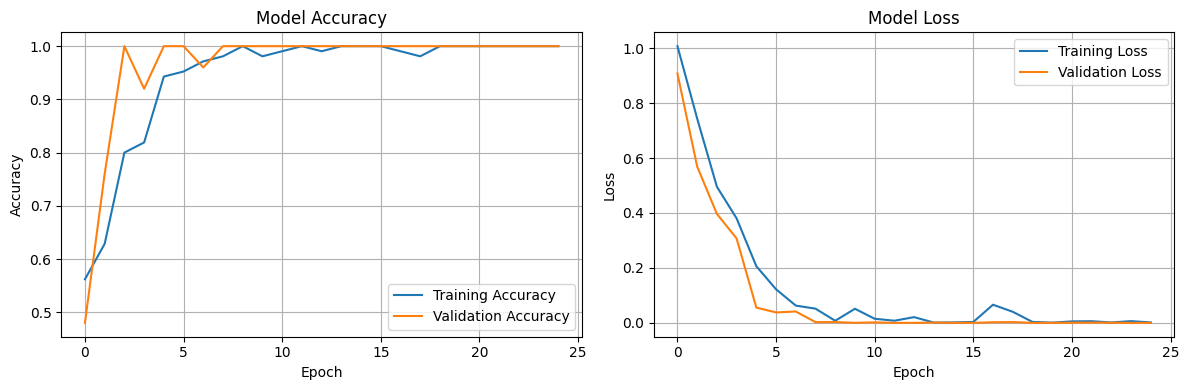

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 📊 Eğitim Sonuçlarının Görselleştirilmesi

Bu bölümde, eğitim sürecindeki **accuracy** (doğruluk) ve **loss** (kayıp) değerlerini grafiklerle görselleştiriyoruz.

### 🔹 Sol Grafik - Model Accuracy:
- **Mavi çizgi**: Eğitim verisi üzerindeki doğruluk (Training Accuracy)
- **Turuncu çizgi**: Doğrulama verisi üzerindeki doğruluk (Validation Accuracy)
- **Beklenen durum:**
  - Her iki çizgi de epoch'lar boyunca yükselmeli
  - Eğitim ve doğrulama accuracy'leri birbirine yakın olmalı
  - Eğitim accuracy çok yüksek ama validation düşükse → **Overfitting** var demektir

### 🔹 Sağ Grafik - Model Loss:
- **Mavi çizgi**: Eğitim kaybı (Training Loss)
- **Turuncu çizgi**: Doğrulama kaybı (Validation Loss)
- **Beklenen durum:**
  - Her iki çizgi de epoch'lar boyunca düşmeli
  - Loss değerleri 0'a yaklaştıkça model daha iyi öğreniyor demektir
  - Validation loss artmaya başlarsa modeli durdurmak gerekir

**Grafiklerin Yorumlanması:**
- Eğer çizgiler birbirine yakınsa: Model iyi genelleme yapıyor ✅
- Eğer eğitim accuracy çok yüksek ama validation düşükse: Overfitting var ⚠️
- Eğer her iki accuracy de düşükse: Underfitting var, model daha karmaşık olmalı 📉

In [26]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 6.8424e-06
Test Accuracy: 1.0000
Test Loss: 0.0000


## ✅ Test Verisi Üzerinde Nihai Değerlendirme

Bu adımda, eğitilmiş modelimizin **validation set** (doğrulama verisi) üzerindeki nihai performansını ölçüyoruz.

**model.evaluate()** fonksiyonu:
- Modeli doğrulama verisi üzerinde test eder
- **Test Accuracy**: Modelin doğru tahmin yüzdesi
- **Test Loss**: Modelin hata miktarı (düşük olması iyidir)

### 🔹 Neden Test Ediyoruz?
- Eğitim sırasında model sadece eğitim verisini görmüştür
- Doğrulama/test verisi, modelin **hiç görmediği** verilerdir
- Bu değerlendirme, modelin **gerçek dünyada** nasıl performans göstereceğini tahmin eder

### 🔹 Başarı Kriterleri:
- **%70-80 Test Accuracy**: İyi bir başlangıç
- **%80-90 Test Accuracy**: Çok iyi performans
- **%90+ Test Accuracy**: Mükemmel (ama overfitting riski var, kontrol edin!)

**Not:** Bu değer, sözlü sunumda hocaya rapor edeceğiniz en önemli metriklerden biridir.

In [27]:
model.save('model1_transfer_learning.h5')

## 💾 Eğitilmiş Modelin Kaydedilmesi

Bu adımda, eğitilmiş modelimizin tüm ağırlıklarını ve mimarisini `.h5` formatında kaydediyoruz.

**model.save()** fonksiyonu:
- Modelin tüm katmanlarını, ağırlıklarını ve ayarlarını tek bir dosyaya kaydeder
- Dosya adı: **model1_transfer_learning.h5**

### 🔹 Neden Kaydediyoruz?
- Modeli tekrar eğitmeden kullanabilmek için
- Daha sonra tahmin yapmak için (prediction)
- Model karşılaştırması yapmak için
- Zaman kazanmak için (eğitim saatler sürebilir)

### 🔹 Modeli Nasıl Yükleriz?
```python
from tensorflow.keras.models import load_model
loaded_model = load_model('model1_transfer_learning.h5')
```

**Sonuç:** Model artık diske kaydedildi ve daha sonra kullanılabilir durumda! ✅

Sınıflar: ['airpods', 'magic_mouse']


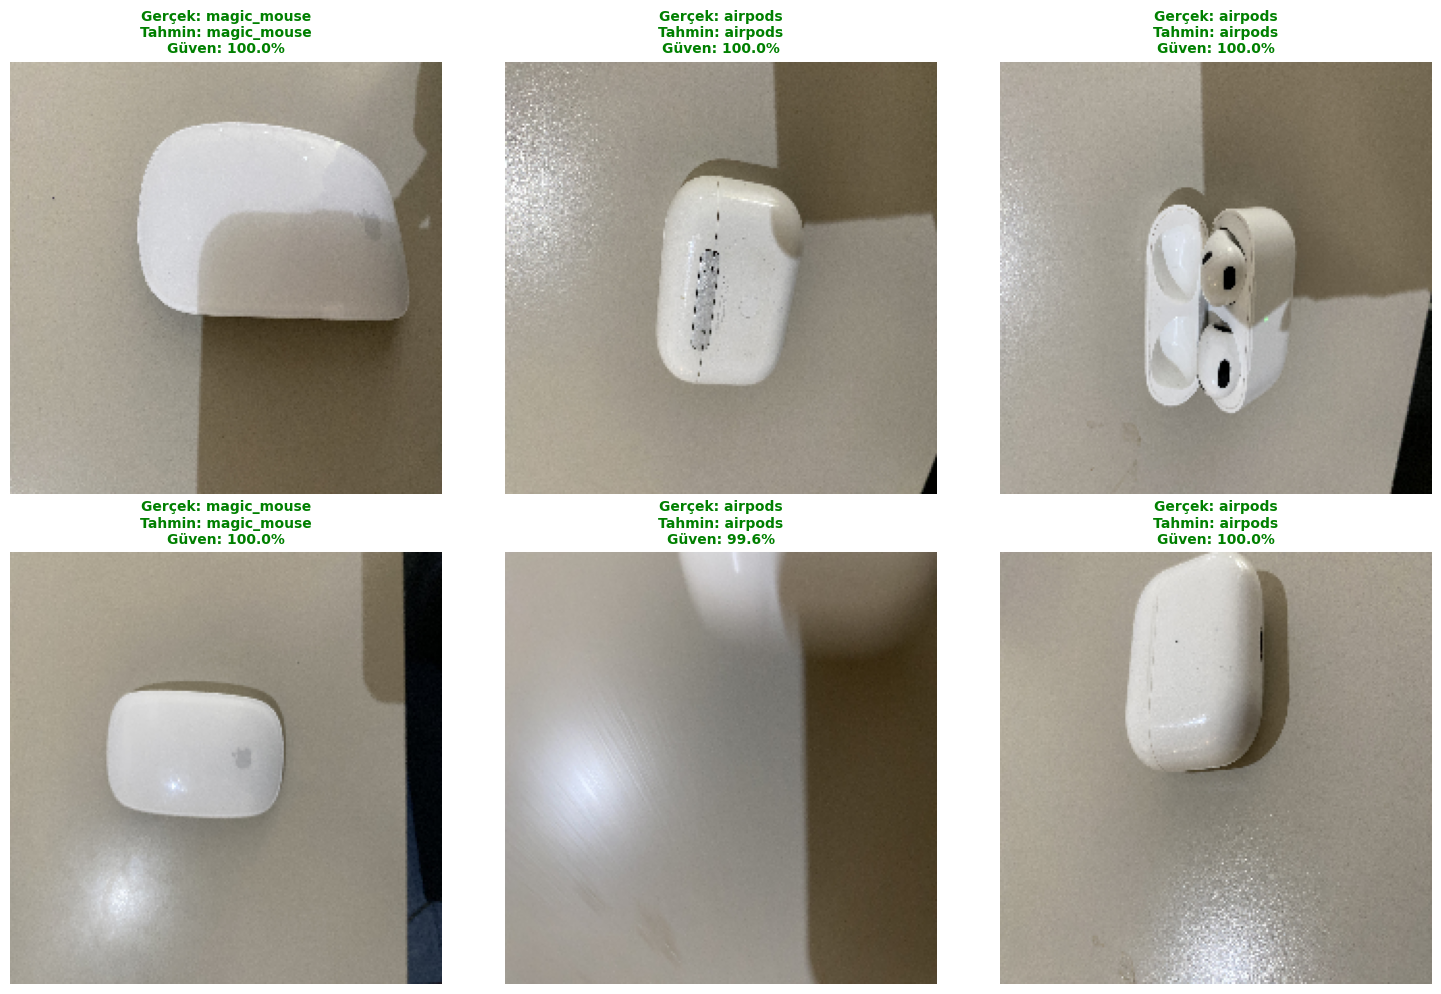


Test Sonucu: 6/6 doğru tahmin (100.0%)


In [29]:
import random
import glob
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    return class_names[predicted_class_idx], confidence, img

class_names = list(train_generator.class_indices.keys())
print(f"Sınıflar: {class_names}")

num_samples = 6
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

all_images = []
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name, '*')
    images = glob.glob(class_path)
    all_images.extend([(img, class_name) for img in images])

if len(all_images) >= num_samples:
    sample_images = random.sample(all_images, num_samples)

    for idx, (img_path, true_label) in enumerate(sample_images):
        predicted_class, confidence, img = predict_image(img_path, model, class_names)

        axes[idx].imshow(img)
        axes[idx].axis('off')

        color = 'green' if predicted_class == true_label else 'red'
        title = f'Gerçek: {true_label}\nTahmin: {predicted_class}\nGüven: {confidence:.1f}%'
        axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()

    correct = sum(1 for img_path, true_label in sample_images
                  if predict_image(img_path, model, class_names)[0] == true_label)
    print(f"\nTest Sonucu: {correct}/{num_samples} doğru tahmin ({correct/num_samples*100:.1f}%)")
else:
    print(f"Yeterli görüntü bulunamadı. En az {num_samples} görüntü gerekli.")

### Çoklu Görüntü Testi

Validation set'inden rastgele görüntüler alıp tahmin yaparak modelin performansını görsel olarak değerlendirelim.

## 📤 PC'den Test Görüntüsü Yükleme

**Adım Adım:**

1. **Hücreyi çalıştırınca yükle butonuna** (📁 Upload) tıkla
2. **PC'nden bir fotoğraf seç** (AirPods veya Magic Mouse)
3. **Yüklenen dosyanın ismini kopyala** (örn: `my_test_image.jpg`)
4. **Aşağıdaki hücrede** `UPLOADED_IMAGE_NAME` değişkenini değiştir
5. **Hücreyi çalıştır** → Model tahmini göreceksin!

**Not:** Yüklenen dosyalar `/content/` klasörüne kaydedilir (geçici, oturum kapanınca silinir)

Lütfen tahmin yapmak istediğiniz bir görseli yükleyin.


Saving IMG_6166.JPG to IMG_6166.JPG

✅ 'IMG_6166.JPG' başarıyla yüklendi.
🔍 Tahmin yapılıyor...



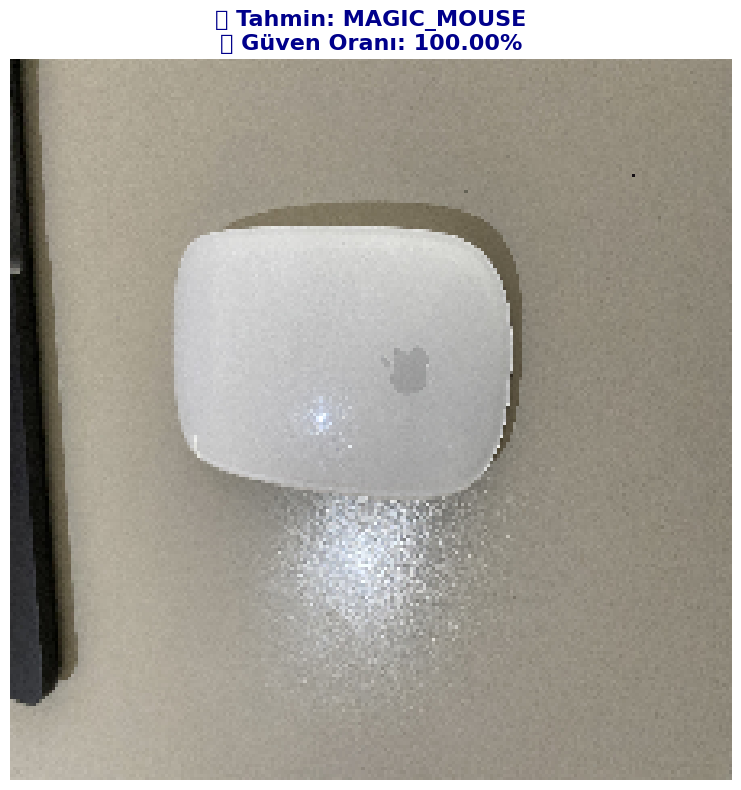


🎯 TAHMİN EDİLEN SINIF: MAGIC_MOUSE
💯 GÜVEN ORANI: 100.00%

✅ Model çok emin!


In [38]:
import google.colab.files
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

if 'predict_image' not in globals():
    def predict_image(img_path, model, class_names):
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx] * 100

        return class_names[predicted_class_idx], confidence, img


print("Lütfen tahmin yapmak istediğiniz bir görseli yükleyin.")
uploaded = google.colab.files.upload()

if uploaded:
    uploaded_file_name = next(iter(uploaded))
    uploaded_image_path = os.path.join(os.getcwd(), uploaded_file_name)

    print(f"\n✅ '{uploaded_file_name}' başarıyla yüklendi.")
    print("🔍 Tahmin yapılıyor...\n")

    if 'model' in globals() and 'class_names' in globals() and 'IMG_SIZE' in globals():
        predicted_class, confidence, img_display = predict_image(uploaded_image_path, model, class_names)

        plt.figure(figsize=(8, 8))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f'🎯 Tahmin: {predicted_class.upper()}\n💯 Güven Oranı: {confidence:.2f}%',
                  fontsize=16, fontweight='bold', color='darkblue')
        plt.tight_layout()
        plt.show()

        print(f"\n{'='*50}")
        print(f"🎯 TAHMİN EDİLEN SINIF: {predicted_class.upper()}")
        print(f"💯 GÜVEN ORANI: {confidence:.2f}%")
        print(f"{'='*50}")

        if confidence > 90:
            print("\n✅ Model çok emin!")
        elif confidence > 70:
            print("\n👍 Model oldukça emin.")
        else:
            print("\n⚠️ Model biraz kararsız, farklı açıdan foto dene.")
    else:
        print("❌ HATA: Model, sınıf isimleri (class_names) veya IMG_SIZE tanımlı değil. Lütfen önceki hücreleri çalıştırın.")
else:
    print("❌ Hiçbir dosya yüklenmedi.")
    print("Lütfen tahmin etmek istediğiniz bir resim dosyası seçtiğinizden emin olun.")

### Tek Görüntü Tahmini

Aşağıdaki hücreyi çalıştırarak bir test görüntüsü ile tahmin yapabilirsiniz. `test_image_path` değişkenini kendi test görüntünüzün yolu ile değiştirin.

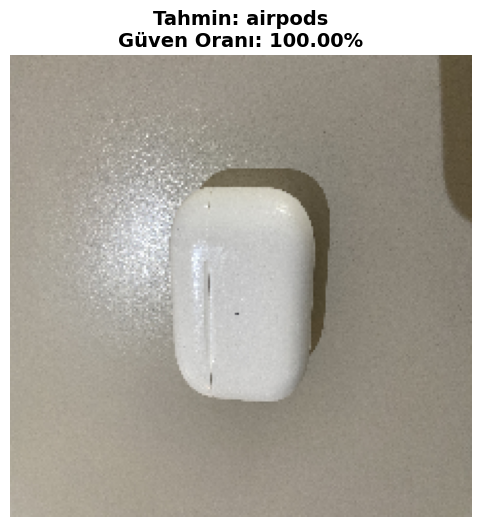

Tahmin Edilen Sınıf: airpods
Güven Oranı: 100.00%


In [39]:
test_image_path = 'dataset/airpods/IMG_6089.JPG'

try:
    predicted_class, confidence, img = predict_image(test_image_path, model, class_names)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Tahmin: {predicted_class}\nGüven Oranı: {confidence:.2f}%',
              fontsize=14, fontweight='bold')
    plt.show()

    print(f"Tahmin Edilen Sınıf: {predicted_class}")
    print(f"Güven Oranı: {confidence:.2f}%")
except Exception as e:
    print(f"Hata: {e}")
    print("Lütfen 'test_image_path' değişkenini geçerli bir görüntü yolu ile değiştirin.")

In [40]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    return class_names[predicted_class_idx], confidence, img

class_names = list(train_generator.class_indices.keys())
print(f"Sınıflar: {class_names}")

Sınıflar: ['airpods', 'magic_mouse']
